In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [5]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, chi=0, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1x=chi,
        # spin1z=chi,
        # spin2z=chi,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    # return hp
    return new_amp
    # return new_phase

In [6]:
mass_ratio = 5
# mass_ratio = 0.95
chi=0.99
total_mass = 100
# approximant = "SEOBNRv4_opt"
approximant = "SEOBNRv4P"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
# t1 = -500
# t1 = -200
t1 = -2000
# t1 = -5000
# t2 = 120
t2 = 70
dt = 0.5
# dt = 0.25
# dt = 0.1
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [7]:
new_times_M.shape


(4140,)

In [8]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, chi=chi, approximant=approximant, distance_mpc=distance_mpc)

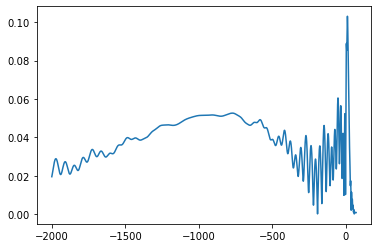

In [9]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)

In [10]:
qs = np.array([5.])
# qs = np.arange(5, 5.1+0.05, 0.05)
# qs = np.linspace(1, 5, 20)
# chis = np.linspace(-0.99, 0.99, 20)
# chis = np.linspace(0, 0.99, 20)
# chis = np.linspace(0, 0.5, 20)

# chis_1 = np.linspace(0, 0.5, 20)
# chis_2 = np.linspace(0.5, 0.8, 40)
# chis = np.concatenate((chis_1, chis_2))

chis = np.linspace(0.5, 0.7, 40)
# chis = np.linspace(0.7, 0.9, 60)

XX, YY = np.meshgrid(qs, chis)
XX = XX.ravel()
YY = YY.ravel()

In [11]:
qs

array([5.])

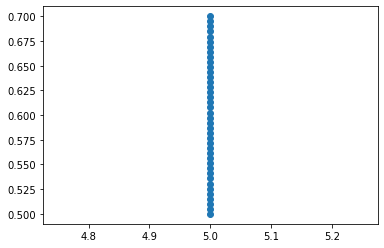

In [12]:
plt.scatter(XX, YY)

In [13]:
num_samples = len(XX)

In [14]:
num_samples

40

In [15]:
%%time
hps = []
for i in range(num_samples):
    mass_ratio = XX[i]
    chi = YY[i]
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, chi=chi, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)
    hps.append(hp)
hps = np.array(hps)

CPU times: user 36.6 s, sys: 500 ms, total: 37.1 s
Wall time: 36.9 s


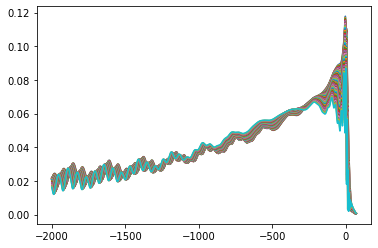

In [16]:
for hp in hps:
    plt.plot(new_times_M, hp)
# plt.xlim(-100, 100)

(-100.0, 100.0)

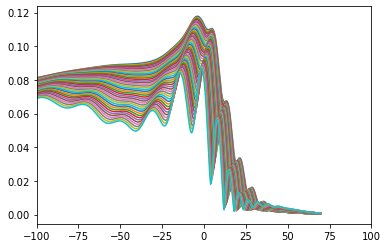

In [17]:
for hp in hps:
    plt.plot(new_times_M, hp)
plt.xlim(-100, 100)
# plt.yscale('log')

In [18]:
theta = np.column_stack((XX, YY))

In [19]:
theta_idxs = np.arange(len(theta))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
theta_training_idxs = theta_idxs[::2]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
theta_training_idxs = np.concatenate((theta_training_idxs, [theta_idxs[-1]]))
theta_validation_idxs = theta_idxs[1:-1:2] 

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# theta_training_idxs = theta_idxs
# theta_validation_idxs = theta_idxs

In [20]:
theta_training_idxs

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 39])

In [21]:
theta_validation_idxs

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37])

In [22]:
len(theta_idxs)

40

In [23]:

len(theta_training_idxs)


21

In [24]:

len(theta_validation_idxs)

19

Text(0.5, 1.0, 'theta train/val distribution')

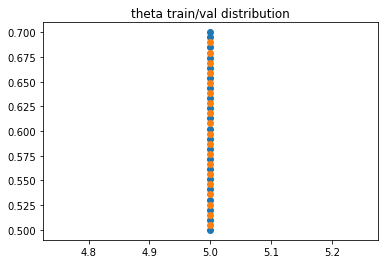

In [25]:
plt.figure()
plt.scatter(theta[theta_training_idxs,0], theta[theta_training_idxs,1])
plt.scatter(theta[theta_validation_idxs,0], theta[theta_validation_idxs,1])
plt.title("theta train/val distribution")

In [26]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [27]:
len(t_idxs)

4140

In [28]:
len(t_training_idxs)

2070

In [29]:
len(t_validation_idxs)

2070

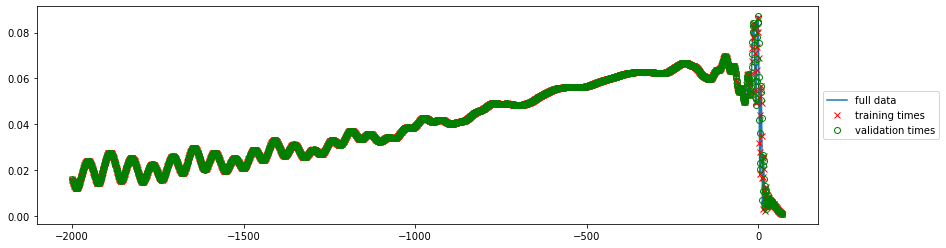

In [30]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[-1], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[-1][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[-1][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

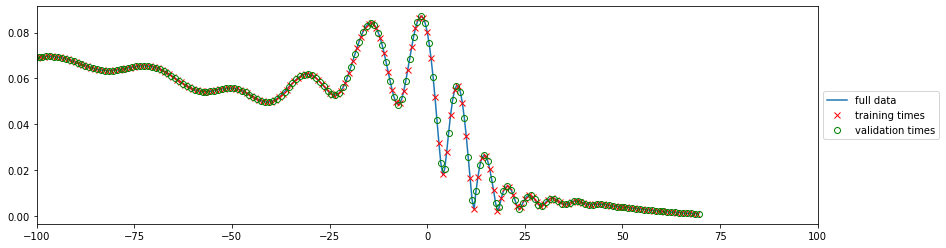

In [31]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[-1], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[-1][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[-1][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [32]:
def build_input_single_q(t, q, chi):
    """
    t is a matrix i.e. shape = (-1, 1)
    q is a float
    chi is a float
    """
    theta = np.array([q, chi])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [33]:
build_input_single_q(np.array([1,2,3]).reshape(-1, 1), 1, 0.5)

array([[1. , 1. , 0.5],
       [2. , 1. , 0.5],
       [3. , 1. , 0.5]])

In [34]:
def build_input_multiple_q(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single_q(t, *theta) for theta in thetas])

In [35]:
build_input_multiple_q(np.array([1,2,3]).reshape(-1, 1), [[1,3], [0.5, 0.4]])

array([[1. , 1. , 3. ],
       [2. , 1. , 3. ],
       [3. , 1. , 3. ],
       [1. , 0.5, 0.4],
       [2. , 0.5, 0.4],
       [3. , 0.5, 0.4]])

In [36]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

t_scaled = t_scaler.fit_transform(new_times_M[:,np.newaxis])
theta_scaled = theta_scaler.fit_transform(theta)

In [37]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [38]:
X_training = build_input_multiple_q(t_scaled[t_training_idxs], theta_scaled[theta_training_idxs])

In [39]:
X_validation = build_input_multiple_q(t_scaled[t_validation_idxs], theta_scaled[theta_validation_idxs])

In [40]:
X_training.shape

(43470, 3)

In [41]:
X_validation.shape

(39330, 3)

In [42]:
hps.shape

(40, 4140)

In [43]:
# y_training = hps[np.ix_(theta_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(theta_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[np.ix_(theta_training_idxs, t_training_idxs)]
y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[np.ix_(theta_validation_idxs, t_validation_idxs)]
y_validation = y_validation.reshape(-1, 1)

In [44]:
y_training.shape

(43470, 1)

In [45]:
y_validation.shape

(39330, 1)

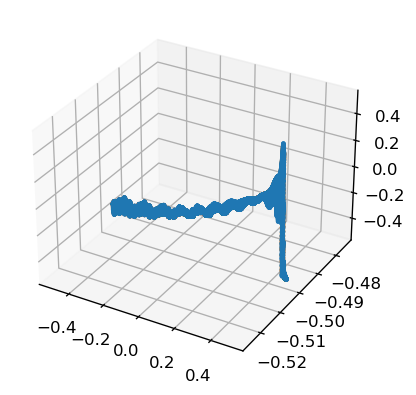

In [46]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,1], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,1], y_validation, s=3)

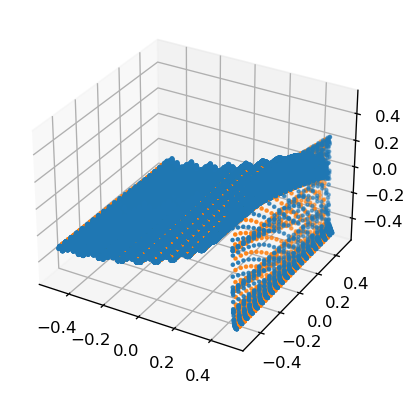

In [47]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='3d')
ax.scatter(X_training[:,0], X_training[:,2], y_training, s=3)
ax.scatter(X_validation[:,0], X_validation[:,2], y_validation, s=3)

In [48]:
64/4/4

4.0

In [49]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1"):
    activation = 'relu'
    units = 256
    n_layers = 3
    # gaussian_projection = units
    gaussian_projection = 16
    # gaussian_projection = 5
    # gaussian_scale = 1

    # gaussian_scale = 50
    # gaussian_scale = 20
    # gaussian_scale = 10
    # gaussian_scale = 5
    # gaussian_scale = 16
    # gaussian_scale = 64/4
    # gaussian_scale = 2 # -500
    gaussian_scale = 2*4 # -2000
    # gaussian_scale = 2*4*2 # -2000, high spin
    # gaussian_scale = 2*4*2*2 # -2000, higher spin
    # gaussian_scale = 2*4*2*2*2

    # model 1: only pass the time through the RFF encoding
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    theta_input = tf.keras.Input(shape=(2,), name='theta_input')
    x_t = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(time_input)
    
    
    if model_version == "1":
        # x = tf.keras.layers.Concatenate()([x_t, q_input])
        x = tf.keras.layers.Concatenate()([x_t, theta_input])
    elif model_version == "2":
        # x_q = FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 0.1)(q_input)
        x_theta = FourierFeatureProjection(gaussian_projection = 16, gaussian_scale = 0.3)(theta_input)
        # x = tf.keras.layers.Concatenate()([x_t, x_q])
        x = tf.keras.layers.Concatenate()([x_t, x_theta])
    else:
        raise ValueError()
    
    # x_q = tf.keras.layers.Dense(units, activation)(q_input)

    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[time_input, theta_input], outputs=x)

    # model 2: pass both time and mass-ratio through RFF encoding
    # model 2 doesn't work so well in the q-direction :)
    # I am guessing it's because the variation of the function in q
    # is simpler than the variation in time.
    # time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    # all_inputs = tf.keras.layers.Concatenate()([time_input, q_input])
    # x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(all_inputs)
    # # x_q = tf.keras.layers.Dense(units, activation)(q_input)
    # # x = tf.keras.layers.Concatenate()([x_t, q_input])
    # # x = tf.keras.layers.Concatenate()([x_t, x_q])
    # for i in range(n_layers):
    #     x = tf.keras.layers.Dense(units, activation)(x)
    # x = tf.keras.layers.Dense(1)(x)
    # model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=80, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    history = model.fit(x=[X_train[:,0], X_train[:,1:]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    return history, model

In [50]:
X_training.shape

(43470, 3)

In [51]:
# epochs=2000
epochs=200
batch_size = 512
# batch_size = 2048
print(batch_size)

learning_rate = 1e-3
# learning_rate = 1e-4
print(learning_rate)

512
0.001


In [52]:
# model_version="1"
model_version="2"

In [53]:
%%time
history, model = run_model(
    X_training,
    y_training,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_validation[:,0], X_validation[:,1:]], y_validation),
    learning_rate=learning_rate,
    threshold=1e-6,
    verbose=1,
    model_version=model_version,
    # threshold=3e-6
    )

Metal device set to: Apple M1 Pro
Epoch 1/200


2022-06-21 22:45:30.188728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 22:45:30.188834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-21 22:45:30.291180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/85 [..............................] - ETA: 29s - loss: 0.0411WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_train_batch_end` time: 0.0061s). Check your callbacks.


2022-06-21 22:45:30.489260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - ETA: 0s - loss: 0.0111

2022-06-21 22:45:31.312237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 1s 12ms/step - loss: 0.0111 - val_loss: 3.8775e-04 - lr: 0.0010
Epoch 2/200
85/85 [==============================] - 1s 10ms/step - loss: 2.7191e-04 - val_loss: 1.9211e-04 - lr: 0.0010
Epoch 3/200
85/85 [==============================] - 1s 12ms/step - loss: 1.7477e-04 - val_loss: 1.3536e-04 - lr: 0.0010
Epoch 4/200
85/85 [==============================] - 1s 10ms/step - loss: 1.4997e-04 - val_loss: 1.2847e-04 - lr: 0.0010
Epoch 5/200
85/85 [==============================] - 1s 10ms/step - loss: 1.4358e-04 - val_loss: 1.3305e-04 - lr: 0.0010
Epoch 6/200
85/85 [==============================] - 1s 10ms/step - loss: 1.4108e-04 - val_loss: 1.3145e-04 - lr: 0.0010
Epoch 7/200
85/85 [==============================] - 1s 10ms/step - loss: 1.4331e-04 - val_loss: 1.5204e-04 - lr: 0.0010
Epoch 8/200
85/85 [==============================] - 1s 11ms/step - loss: 1.4872e-04 - val_loss: 1.2765e-04 - lr: 0.0010
Epoch 9/200
85/85 [=============================

In [54]:
# 57 epochs
# 8 mins

# loss = 8e-7
# val loss = 1e-6

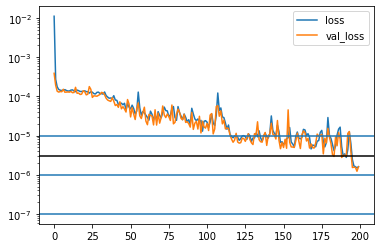

In [55]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")


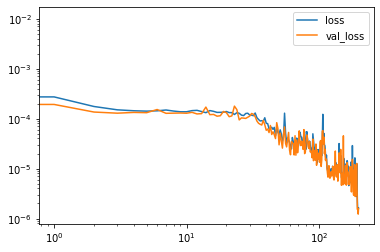

In [56]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

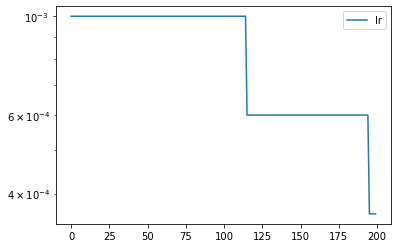

In [57]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 2)]          0           []                               
                                                                                                  
 fourier_feature_projection (Fo  (None, 32)          16          ['time_input[0][0]']             
 urierFeatureProjection)                                                                          
                                                                                                  
 fourier_feature_projection_1 (  (None, 32)          32          ['theta_input[0][0]']        

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [60]:
model.layers

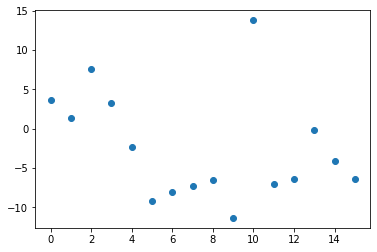

In [61]:
try:
    w=model.layers[1].weights[0].numpy()[0]
except:
    w=model.layers[2].weights[0].numpy()[0]
plt.scatter(range(len(w)), w)

In [62]:
test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

2022-06-21 22:48:31.924496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [63]:
test_input.shape

(4140, 3)

In [64]:
%%timeit
model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

412 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


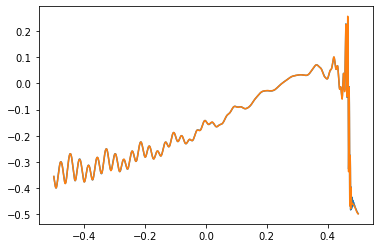

In [65]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

(0.3, 0.5)

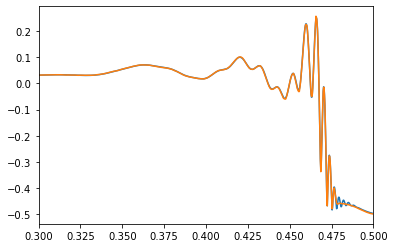

In [66]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(0.3, 0.5)
# plt.yscale('log')

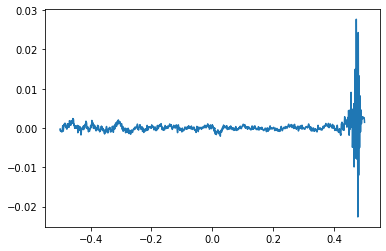

In [67]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]]-test_yhat[:,0])
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

In [68]:
tf.keras.losses.mean_squared_error(hps_scaled[theta_validation_idxs[-1]], test_yhat[:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=2.6060677e-06>

In [69]:
theta_validation_idxs.shape

(19,)

In [70]:
t_validation_idxs.shape

(2070,)

In [71]:
np.mean((hps_scaled[theta_validation_idxs[-1]]-test_yhat[:,0])**2)

2.6060673081627857e-06

In [72]:
yhat_train = model.predict([X_training[:,0], X_training[:,1:]], verbose=0)

shape_ = (theta_training_idxs.shape[0], t_training_idxs.shape[0])
print(shape_)

yhat_train = yhat_train.reshape(shape_)

(21, 2070)


In [73]:
mse_train = tf.keras.losses.mean_squared_error(y_training.reshape(shape_), yhat_train)

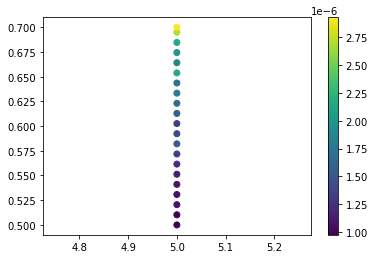

In [74]:
plt.figure()
plt.scatter(theta[theta_training_idxs,0], theta[theta_training_idxs,1], c=mse_train)
plt.colorbar()

In [75]:
worst_idx = np.argmax(mse_train)
worst_idx

20

(-100.0, 100.0)

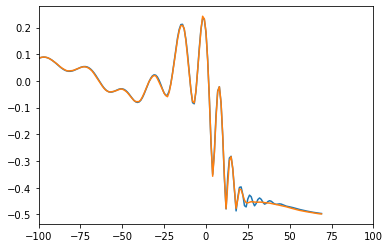

In [76]:
plt.figure()
plt.plot(new_times_M[t_training_idxs], y_training.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_training_idxs], yhat_train[worst_idx])
plt.xlim(-100, 100)

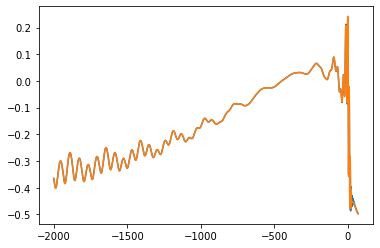

In [77]:
plt.figure()
plt.plot(new_times_M[t_training_idxs], y_training.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_training_idxs], yhat_train[worst_idx])
# plt.xlim(-100, 100)

In [78]:
yhat_val = model.predict([X_validation[:,0], X_validation[:,1:]], verbose=0)

shape_ = (theta_validation_idxs.shape[0], t_validation_idxs.shape[0])
print(shape_)

yhat_val = yhat_val.reshape(shape_)

(19, 2070)


In [79]:
theta_validation_idxs.shape

(19,)

In [80]:
hps_scaled.shape

(40, 4140)

In [81]:
mse_val = tf.keras.losses.mean_squared_error(y_validation.reshape(shape_), yhat_val)

In [82]:
theta.shape

(40, 2)

In [83]:
worst_idx = np.argmax(mse_val)
worst_idx

18

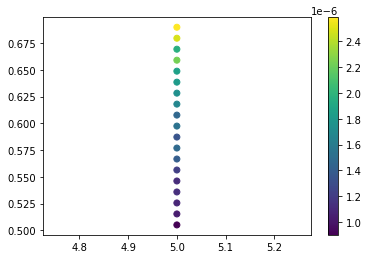

In [84]:
plt.figure()
plt.scatter(theta[theta_validation_idxs,0], theta[theta_validation_idxs,1], c=mse_val)
plt.colorbar()

In [85]:
yhat_val.shape

(19, 2070)

In [86]:
theta[theta_validation_idxs][worst_idx]

array([5.        , 0.68974359])

In [87]:
theta[theta_validation_idxs][worst_idx-1]

array([5.        , 0.67948718])

(-100.0, 100.0)

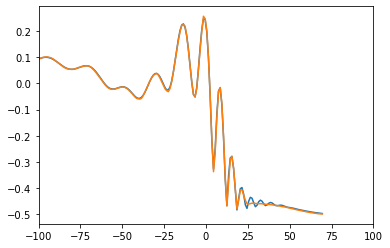

In [88]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_validation_idxs], yhat_val[worst_idx])
plt.xlim(-100, 100)

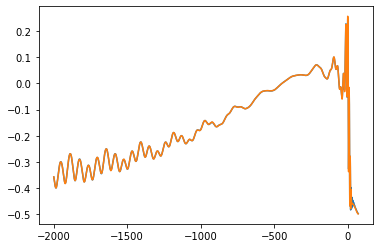

In [89]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[worst_idx])
plt.plot(new_times_M[t_validation_idxs], yhat_val[worst_idx])
# plt.xlim(-100, 100)

(-100.0, 100.0)

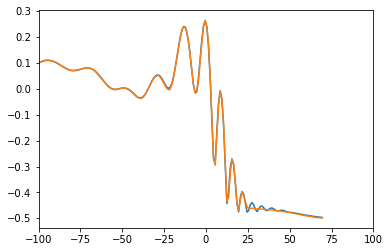

In [90]:
plt.figure()
plt.plot(new_times_M[t_validation_idxs], y_validation.reshape(shape_)[17])
plt.plot(new_times_M[t_validation_idxs], yhat_val[17])
plt.xlim(-100, 100)

In [95]:
t_scaled

array([[-0.5       ],
       [-0.4997584 ],
       [-0.49951679],
       ...,
       [ 0.49951679],
       [ 0.4997584 ],
       [ 0.5       ]])

In [120]:
StoM(1/4096, 60)

0.8261126445190531

In [130]:
StoM(1/2048, 60)

1.6522252890381062

In [131]:
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
test_input = build_input_single_q(t_scaler.transform(np.arange(-10000, 100, 1.65)[:,np.newaxis]), *theta_scaled[theta_validation_idxs[-1]])

In [132]:
test_input.shape

(6122, 3)

In [133]:
%%timeit
model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

584 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [134]:
%%timeit
model([test_input[:,0], test_input[:,1:]])

6.67 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
@tf.function
def run_inference(test_input):
    return model([test_input[:,0], test_input[:,1:]])

In [299]:
@tf.function(jit_compile=None, reduce_retracing=True)
def run_inference_exp_comp(test_input):
    return model([test_input[:,0], test_input[:,1:]])

In [295]:
%%timeit
run_inference(test_input)

5.79 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [294]:
%%time
_ = run_inference(test_input)

CPU times: user 6.95 ms, sys: 19.9 ms, total: 26.8 ms
Wall time: 25.6 ms


In [300]:
%%timeit
run_inference_exp_comp(test_input)

2022-06-21 23:00:47.035692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6.22 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [251]:
%%time
_ = run_inference_exp_comp(test_input)

CPU times: user 10 ms, sys: 7.02 ms, total: 17.1 ms
Wall time: 20 ms
